### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-11/04/20
#### Clasificacion de imagenes motoras en EEG con Fine Tuning
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical

##### VGG16
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

##### InceptionV3
##### Sujeto 1
##### Accuracy = 45.49%
##### Kappa = 0.2731

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [9]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (299, 299) #ancho, alto
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((2816,1000,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      x = abs(coef)
      temporal[j*128:(j+1)*128, :, 0] = x
      temporal[j*128:(j+1)*128, :, 1] = x
      temporal[j*128:(j+1)*128, :, 2] = x
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [13]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

66.0605704209217
58.92652956329641
0.002633029815965031
0.0028018946790724928
3.8612014821606695
3.7636597542096775


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 67.0
x_test /= 67.0

In [16]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.98597866
0.87950045
3.9298953e-05
4.1819323e-05
0.05762994
0.056173973


In [17]:
base_model = InceptionV3(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

87916544/87910968 [==============================] - 1s 0us/step


In [18]:
for layer in base_model.layers[:-12]:
  layer.trainable = False

for layer in base_model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4eed7fd4e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e4570f2b0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4e4570f5c0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f4e4570ff60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e4570fe80> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4e4417b860> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f4e4417bda0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e441870f0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4e441817f0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f4e44181fd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4e453fc3c8> False
<tensorflow.python.keras.layers.c

In [0]:
def fine_tuning():
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
9/9 - 1s - loss: 1.6717 - accuracy: 0.4549
kappa:  0.27314814814814814
confusion matrix:
 [[32 27  4  9]
 [27 39  3  3]
 [11 12 23 26]
 [ 4 16 15 37]]


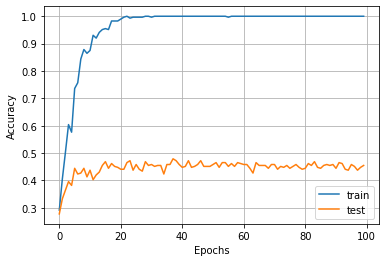

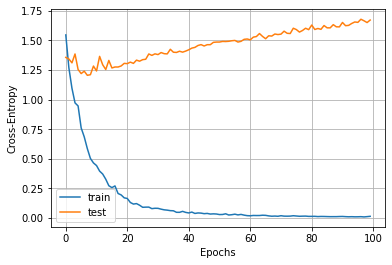

Iteration: 2
9/9 - 1s - loss: 1.6636 - accuracy: 0.4549
kappa:  0.27314814814814814
confusion matrix:
 [[37 17  9  9]
 [32 27  7  6]
 [11  5 30 26]
 [ 6 11 18 37]]


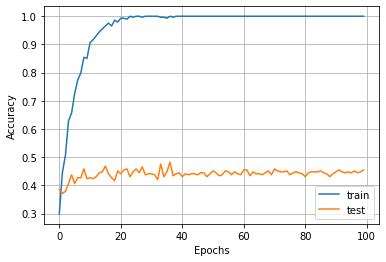

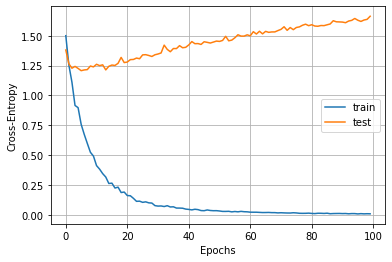


Resultados:
loss: [1.6716541051864624, 1.663599967956543]
accuracy: [0.4548611044883728, 0.4548611044883728]
kappa: [0.27314814814814814, 0.27314814814814814]


In [24]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = fine_tuning()

  history = model.fit(x_train, y_train, epochs=100, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 55,358,500
Trainable params: 33,949,444
Non-trainable params: 21,409,056
_________________________________________________________________


In [26]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4549
std: (+/- 0.0000)
Mean Kappa: 0.2731
std: (+/- 0.0000)
Max Accuracy: 0.4549
Max Kappa: 0.2731
